# Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy wfdb matplotlib

In [2]:
import os
import configparser

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.io import savemat

import wfdb

from denoising import preprocess

In [3]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [4]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw/nsrdb-1.0.0')
FILTERED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/filtered/mecg/nsrdb-1.0.0')

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(FILTERED_DATA_DIR, exist_ok=True)

SIZE = 18
SAMPLING_RATE = 128

In [5]:
def get_filenames_nsrdb(data_dir : str = RAW_DATA_DIR) -> np.ndarray:
    # 128 hz, 2 channels, 91648 mins
    # all middle-aged, no significant arrhythmias
    # 5 men and 13 women
    
    extra_files = ['ANNOTATORS', 'RECORDS', 'SHA256SUMS'] 
    fnames = [f for f in os.listdir(data_dir)]
    fnames_trunc = set(
        os.path.join(data_dir, fname.split('.')[0])
        for fname in fnames
    ) # get subject number (multiple files)
    
    for f in extra_files:
        x = f'{data_dir}/{f}'
        if x in fnames_trunc:
            fnames_trunc.remove(x)
    
    return np.array(sorted(fnames_trunc), dtype=str) 

In [6]:
filenames = get_filenames_nsrdb()

In [7]:
filenames

array(['/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16265',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16272',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16273',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16420',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16483',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16539',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16773',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16786',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/16795',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/17052',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/17453',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/18177',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/18184',
       '/home/rchong3/git/FECG-extraction/data/raw/nsrdb-1.0.0/19088',
      

# Outlier Analysis

In [8]:
samp = wfdb.rdsamp(filenames[0])
print(samp)

(array([[-0.165, -0.325],
       [-0.155, -0.325],
       [-0.195, -0.305],
       ...,
       [-0.05 , -0.095],
       [-0.05 , -0.085],
       [-0.05 , -0.085]]), {'fs': 128, 'sig_len': 11730944, 'n_sig': 2, 'base_date': None, 'base_time': datetime.time(8, 4), 'units': ['mV', 'mV'], 'sig_name': ['ECG1', 'ECG2'], 'comments': ['32 M']})


In [9]:
start_indices = (
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    35 * 128,
    33 * 128,
    28 * 128,
    31 * 128,
    24 * 128
)

Selected starting indices based on visual inspection using https://www.physionet.org/lightwave/?db=nsrdb/1.0.0

In [10]:
def load_ecg_nsrdb(fname : str, start : int = 0, end : int = -1) -> np.ndarray:
    signal, _ = wfdb.rdsamp(fname)
    return signal[start:end,0] if end != -1 else signal[start:,0]

In [ ]:
winlen = 128 * 60

for i in range(SIZE):
    signal = load_ecg_nsrdb(filenames[i], start_indices[i])
    variances = []
    for j in range(len(signal) // winlen):
        start = j * winlen
        end = start + winlen
        variances.append(np.var(signal[start:end]))
    plt.title(f'Subject {i}: {filenames[i]}')
    plt.plot(variances)
    plt.show()
    variances = np.array(variances)
    print('Variance Stats')
    print('mean:', np.mean(variances))
    print('std:', np.std(variances))

In [12]:
end_indices = (
    1300 * 60 * 128,
    0, # exclude due to noisiness
    1200 * 60 * 128,
    1250 * 60 * 128,
    1250 * 60 * 128,
    1400 * 60 * 128,
    1280 * 60 * 128,
    1380 * 60 * 128,
    1220 * 60 * 128,
    1250 * 60 * 128,
    1220 * 60 * 128,
    1320 * 60 * 128,
    1220 * 60 * 128,
    1200 * 60 * 128,
    1150 * 60 * 128,
    1190 * 60 * 128,
    1190 * 60 * 128,
    1250 * 60 * 128
)

Selected ending indices based on visual inspection of window variance

# Filtering Analysis

Preprocessing pipeline consists of an FIR filter to eliminate powerline noise and baseline drift followed by Savitsky Golay for smoothing and a wavelet filter. Each filtering step is tested and selected added in each of the following sections.

In [13]:
preprocess_params = {}

## FIR Filter

In [14]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

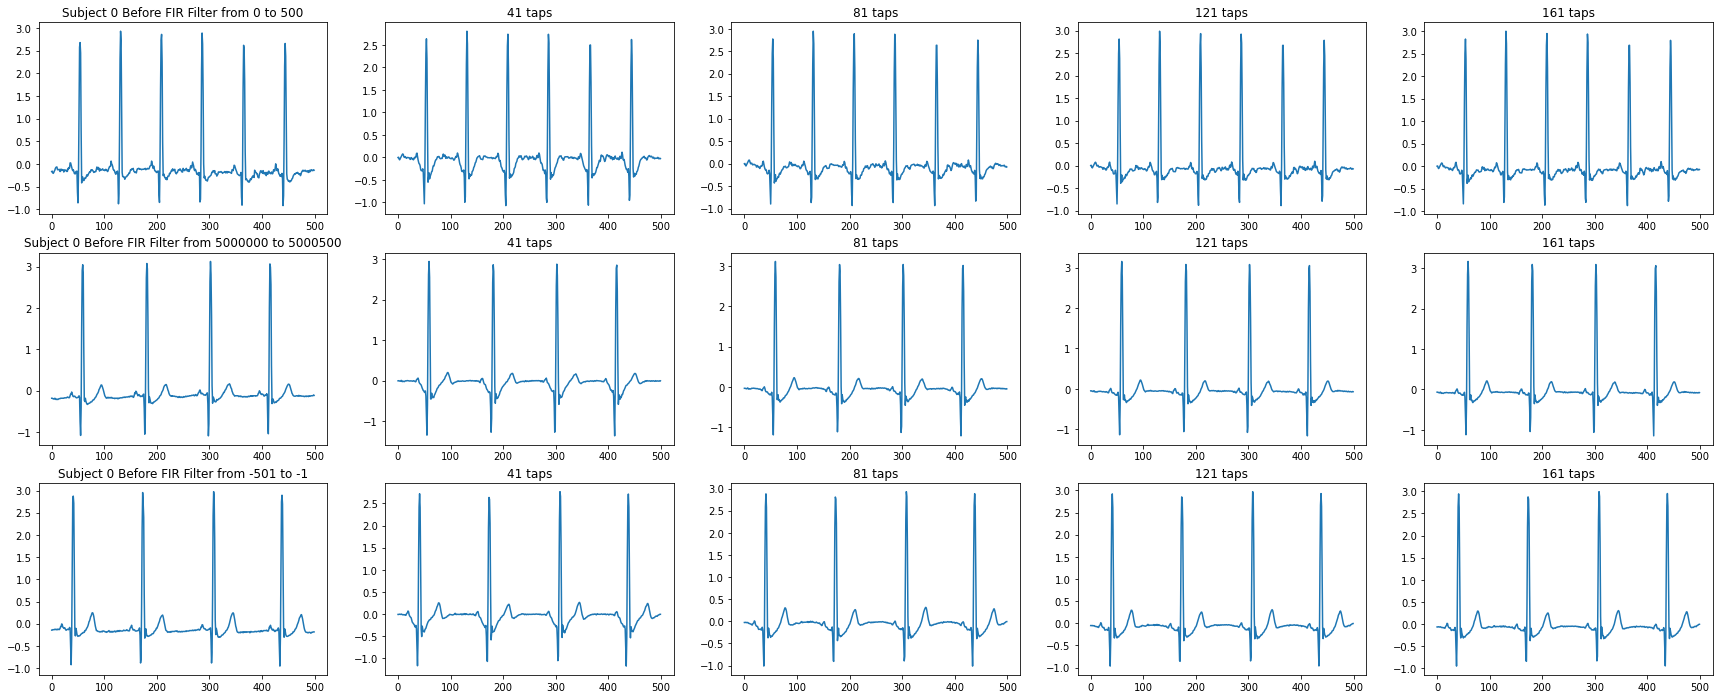

In [15]:
preprocess_params['numtaps'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor
segments = ((0, 500), (5000000, 5000500), (-501, -1))

taps_delta = 40
taps_start = 41

for i in range(subset_len):
    fig, axs = plt.subplots(nrows=len(segments), ncols=5, figsize=(30, 4*len(segments)))
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_nsrdb(filenames[ind], start_indices[ind], end_indices[ind]), SAMPLING_RATE, **preprocess_params)
    
    for i, (start, stop) in enumerate(segments):
        axs[i][0].set_title(f'Subject {ind} Before FIR Filter from {start} to {stop}')
        axs[i][0].plot(sig_window[start:stop])
        
    for j in range(1, 5):
        taps = taps_delta * (j - 1) + taps_start
        preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, numtaps=taps)

        for i, (start, stop) in enumerate(segments):
            axs[i][j].set_title(f'{taps} taps')
            axs[i][j].plot(preprocessed_signal[start:stop])
            
    plt.show()

In [16]:
preprocess_params['numtaps'] = 161

## Savitzky Golay Filter

In [17]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

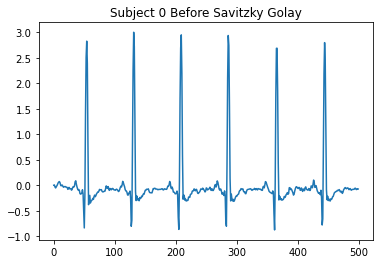

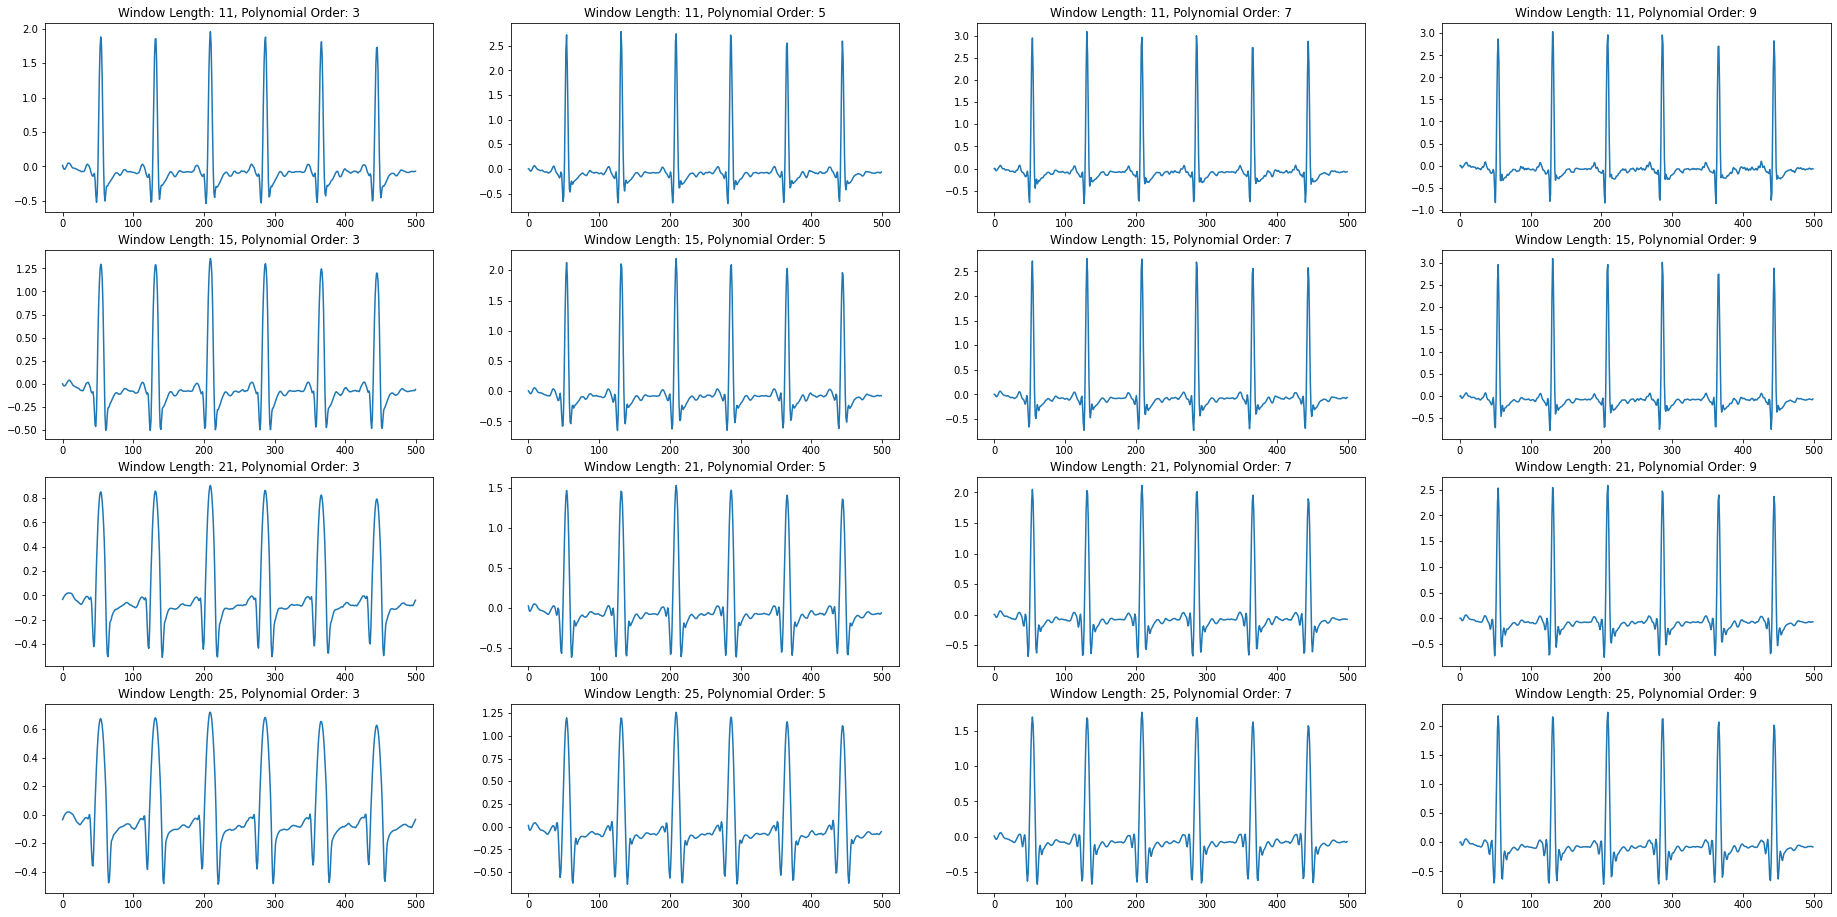

In [18]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor

win_cand = (11, 15, 21, 25)
ord_cand = (3, 5, 7, 9)
win_cand_count = len(win_cand)
ord_cand_count = len(ord_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_nsrdb(filenames[ind], start_indices[ind], end_indices[ind]), SAMPLING_RATE, **preprocess_params)
    
    plt.title(f'Subject {ind} Before Savitzky Golay')
    plt.plot(sig_window[:500])
    
    fig, axs = plt.subplots(nrows=win_cand_count, ncols=ord_cand_count, figsize=(8 * win_cand_count, 4 * ord_cand_count))
    for j in range(win_cand_count):
        for k in range(ord_cand_count):
            winlen = win_cand[j]
            polyorder = ord_cand[k]
            preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, winlen=winlen, polyorder=polyorder)
            axs[j][k].set_title(f'Window Length: {winlen}, Polynomial Order: {polyorder}')
            axs[j][k].plot(preprocessed_signal[:500])

    plt.show()

In [19]:
preprocess_params['winlen'] = 15
preprocess_params['polyorder'] = 5

## Wavelet Filter

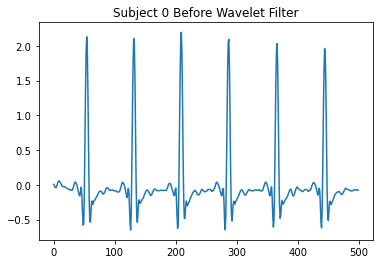

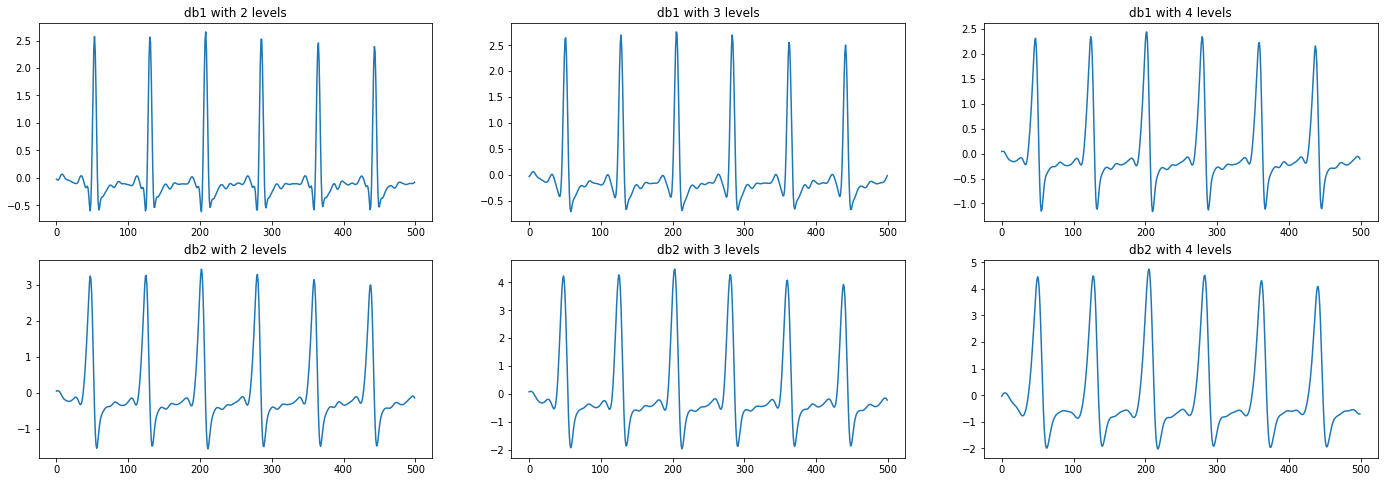

In [20]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

shorten_factor = SIZE
subset_len = SIZE // shorten_factor

family = 'db'
wave_cand = (1, 2)
wave_cand_count = len(wave_cand)
levels_cand = (2, 3, 4)
levels_cand_count = len(levels_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_nsrdb(filenames[ind], start_indices[ind], end_indices[ind]), SAMPLING_RATE, **preprocess_params)
    
    plt.title(f'Subject {ind} Before Wavelet Filter')
    plt.plot(sig_window[:500])
    fig, axs = plt.subplots(nrows=wave_cand_count, ncols=levels_cand_count, figsize=(8 * levels_cand_count, 4 * wave_cand_count))
    for j in range(wave_cand_count):
        for k in range(levels_cand_count):
            wavelet = f'{family}{wave_cand[j]}'
            lvl = levels_cand[k]
            sig_window, _ = preprocess(sig_window, SAMPLING_RATE, wavelet=wavelet, lvl=lvl)
            axs[j][k].set_title(f'{wavelet} with {lvl} levels')
            axs[j][k].plot(sig_window[:500])

    plt.show()

In [21]:
preprocess_params['wavelet'] = 'db1'
preprocess_params['lvl'] = 3

# Filter All and Save

In [22]:
def save_data_nsrdb(filenames : np.ndarray, start_indices : tuple[int], end_indices : tuple[int], preprocess_params : dict, data_dir : str = FILTERED_DATA_DIR): 
    for fname, start, end in zip(filenames, start_indices, end_indices):
        raw_sig = load_ecg_nsrdb(fname, start, end)
        filt_sig, light_filt_sig = preprocess(raw_sig, SAMPLING_RATE, **preprocess_params)
        d = {'filtered' : filt_sig, 'light': light_filt_sig, 'raw' : raw_sig}
        savemat(file_name=os.path.join(FILTERED_DATA_DIR, os.path.basename(fname)), mdict=d)

In [23]:
save_data_nsrdb(filenames, start_indices, end_indices, preprocess_params)